In [2]:
import numpy as np
from tqdm import tqdm
from echo_lv.data import LV_CAMUS_Dataset, LV_EKB_Dataset
from echo_lv.metrics import dice as dice_np
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import sigmoid
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchsummary import summary
from echo_lv.utils import AverageMeter
import segmentation_models_pytorch as smp
from mod_unet import UNet as mUNet
from com_unet import UNet as cUNet

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

random_state = 17
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.backends.cudnn.deterministic = True

cuda:1


In [4]:
common_unet = cUNet(1, 1, False).to(device)
common_unet.load_state_dict(torch.load('common_unet_wo_bn.pth'))
common_unet.eval();
# modified_unet = mUNet(1, 1).to(device)
# modified_unet.load_state_dict(torch.load('modified_unet.pth'))
# modified_unet.eval();

## Обычная Unet

In [5]:
folds = 10
lv_camus = LV_CAMUS_Dataset(img_size = (388,388), classes = {0, 1}, folds=folds)
lv_camus.set_state('valid', 0)

In [6]:
img, msk, *_ = lv_camus[5]
imgs = torch.tensor(np.expand_dims(img, axis=0))
msks = torch.tensor(np.expand_dims(msk, axis=0))
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)

(-92.0, 480.0, 480.0, -92.0)

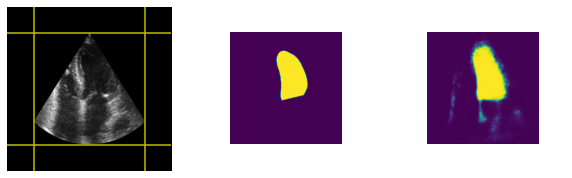

In [7]:
outputs = common_unet(imgs.to(device).float())
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(imgs[0,0,:,:], cmap = plt.cm.gray)
plt.vlines(92, 0, 571, colors='y',)
plt.vlines(480, 0, 571, colors='y')
plt.hlines(92, 0, 571, colors='y',)
plt.hlines(480, 0, 571, colors='y')
plt.axis('off')
plt.subplot(132)
m = msks[0,0,:,:].cpu().detach().numpy()
plt.xlim(-92, 480)
plt.ylim(-92, 480)
# plt.vlines(92, 0, 571, colors='y',)
# plt.vlines(480, 0, 571, colors='y')
# plt.hlines(92, 0, 571, colors='y',)
# plt.hlines(480, 0, 571, colors='y')
plt.gca().invert_yaxis()
plt.imshow(m)
plt.axis('off')
# plt.title('Экспертная маска ЛЖ')
plt.subplot(133)
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.xlim(-92, 480)
plt.ylim(-92, 480)
# plt.vlines(-92, -92, 480, colors='y',)
# plt.vlines(480, -92, 480, colors='y')
# plt.hlines(-92, -92, 480, colors='y',)
# plt.hlines(480, -92, 480, colors='y')
plt.gca().invert_yaxis()
plt.imshow(o)
# plt.title('Выходное изображение СНС')
plt.axis('off')

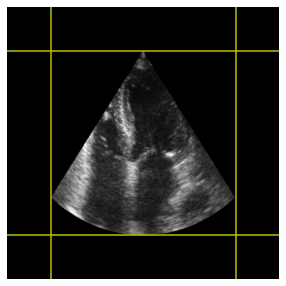

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(imgs[0,0,:,:], cmap = plt.cm.gray)
plt.vlines(92, 0, 571, colors='y',)
plt.vlines(480, 0, 571, colors='y')
plt.hlines(92, 0, 571, colors='y',)
plt.hlines(480, 0, 571, colors='y')
plt.axis('off')
plt.savefig('cnn/us_image_common_unet.png', bbox_inches='tight', pad_inches=0,)

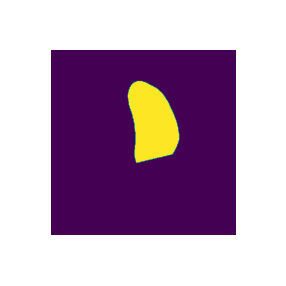

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(m)
plt.xlim(-92, 480)
plt.ylim(-92, 480)
plt.gca().invert_yaxis()
plt.axis('off')
plt.savefig('cnn/mask_common_unet.png', bbox_inches='tight', pad_inches=0,)

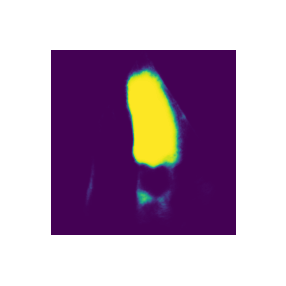

In [8]:
plt.figure(figsize=(5,5))
plt.xlim(-92, 480)
plt.ylim(-92, 480)
plt.gca().invert_yaxis()
plt.imshow(o)
plt.axis('off')
plt.savefig('cnn/result_common_unet.png', bbox_inches='tight', pad_inches=0,)

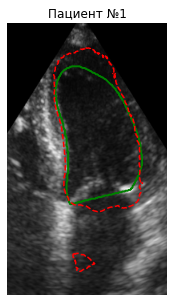

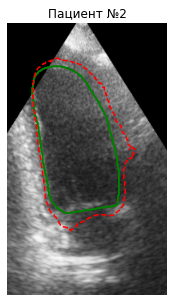

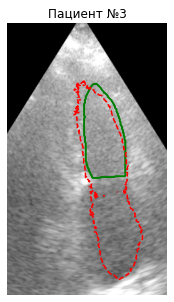

In [14]:
indexes = [5, 30, 50]
xs = [(100,300), (100,300), (100,300)]
ys = [(10,350), (10,350), (10,350),]
for i, (index, xlim, ylim) in enumerate(zip(indexes, xs, ys)):
    img, msk, *_ = lv_camus[index]
    imgs = torch.tensor(np.expand_dims(img, axis=0))
    msks = torch.tensor(np.expand_dims(msk, axis=0))
    shape = imgs.shape
    imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
    shape = imgs.shape
    imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
    outputs = common_unet(imgs.to(device).float())
    m = msks[0,0,:,:].cpu().detach().numpy()
    o = sigmoid(outputs).cpu().detach().numpy()[0][0]
    plt.figure(figsize=(5,5))
    plt.imshow(img[0], cmap = plt.cm.gray)
    plt.contour(m, 1, colors='g')
    plt.contour(o, 1, colors='r', linestyles='dashed')
    plt.axis('off')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.title('Пациент №' + str(i+1))
    plt.savefig('cnn/us_image_res_common_unet_'+str(i+1) +'.png', bbox_inches='tight', pad_inches=0,)

## Модифицированная архитектура

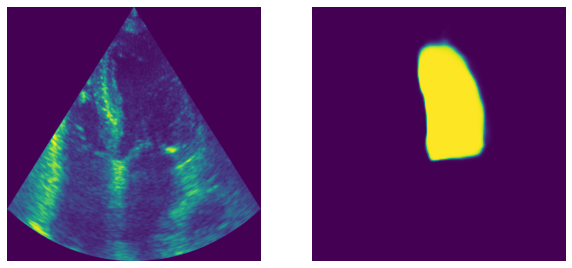

In [15]:
folds = 10
lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=folds)
lv_camus.set_state('valid', 0)
img, msk, *_ = lv_camus[5]
imgs = torch.tensor(np.expand_dims(img, axis=0))
msks = torch.tensor(np.expand_dims(msk, axis=0))

outputs = sigmoid(modified_unet(imgs.to(device).float()))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(imgs[0,0,:,:])
plt.axis('off')
plt.subplot(122)
o = outputs[0,0,:,:].cpu().detach().numpy()
plt.imshow(o)
plt.axis('off')
# plt.subplot(133)
m = msks[0,0,:,:].cpu().detach().numpy()

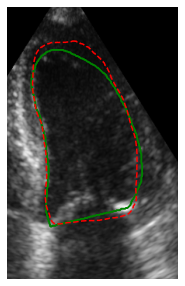

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(imgs[0,0,], cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(180,400)
plt.ylim(30,380)
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_modified_unet.png', bbox_inches='tight', pad_inches=0,)

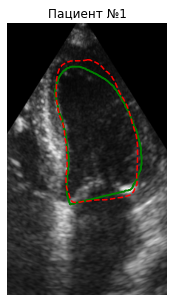

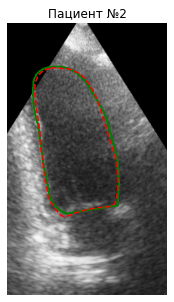

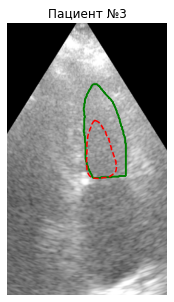

In [19]:
indexes = [5, 30, 50]
xs = [(100 * 512/388,300 * 512/388), (100 * 512/388,300* 512/388), (100* 512/388,300* 512/388)]
ys = [(10* 512/388,350* 512/388), (10* 512/388,350* 512/388), (10* 512/388,350* 512/388),]
for i, (index, xlim, ylim) in enumerate(zip(indexes, xs, ys)):
    img, msk, *_ = lv_camus[index]
    imgs = torch.tensor(np.expand_dims(img, axis=0))
    msks = torch.tensor(np.expand_dims(msk, axis=0))
    outputs = modified_unet(imgs.to(device).float())
    m = msks[0,0,:,:].cpu().detach().numpy()
    o = sigmoid(outputs).cpu().detach().numpy()[0][0]
    plt.figure(figsize=(5,5))
    plt.imshow(img[0], cmap = plt.cm.gray)
    plt.contour(m, 1, colors='g')
    plt.contour(o, 1, colors='r', linestyles='dashed')
    plt.axis('off')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.title('Пациент №' + str(i+1))
    plt.savefig('cnn/us_image_res_modified_unet_'+str(i+1) +'.png', bbox_inches='tight', pad_inches=0,)

In [20]:
388 + 92 + 92

572